In [ ]:
!pip install numpy pandas scipy matplotlib seaborn scikit-learn networkx torch torchvision torchaudio
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 325.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.4 MB/s eta 0:00:00


In [ ]:
# Standard Libraries
import os
import json
import gc
import re

# Data Manipulation & Analysis
import numpy as np
import pandas as pd
from scipy.special import rel_entr

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# PyTorch & PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear
from torch.autograd import Function

from torch_geometric.nn import SAGEConv, GATConv, GCNConv
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Linear

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Sklearn Utilities
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, f1_score



# Set the device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
td = pd.read_csv('/content/creditcard.csv')
print("Transactions:", td.shape[0])
print("Features:", td.shape[1])

Transactions: 284807
Features: 31


In [ ]:
fraud_pct = td['Class'].mean() * 100
print(f"\nFraud proportion: {fraud_pct:.4f}% ({td['Class'].sum()} frauds / {len(td)} total)\n")


Fraud proportion: 0.1727% (492 frauds / 284807 total)



In [ ]:
temp = td["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index, 'values': temp.values})

total = temp.sum()
df['percent'] = df['values'] / total * 100

# Now df has the counts and percentages, you can print or use it as needed:
print(df)

   Class  values    percent
0      0  284315  99.827251
1      1     492   0.172749


In [ ]:
td['Hour'] = ((td['Time'] % 86400) // 3600).astype(int)
# night: 0-5 as 'night' by default
td['is_night'] = td['Hour'].isin([0,1,2,3,4,5])

# Fraud counts by hour
hour_summary = td.groupby('Hour')['Class'].agg(['count','sum'])
hour_summary['fraud_rate'] = hour_summary['sum'] / hour_summary['count']

In [ ]:
class_0 = td.loc[td['Class'] == 0]["Time"]
class_1 = td.loc[td['Class'] == 1]["Time"]


In [ ]:
c0 = td.loc[td['Class'] == 0]
c1 = td.loc[td['Class'] == 1]

kl_divergences = {}

for feature in td.columns[1:29]:
    if c0[feature].var() == 0 or c1[feature].var() == 0:
        continue

    # Calculate KL Divergence
    min_val = min(c0[feature].min(), c1[feature].min())
    max_val = max(c0[feature].max(), c1[feature].max())
    range_bins = np.linspace(min_val, max_val, 100)

    p, _ = np.histogram(c0[feature], bins=range_bins, density=True)
    q, _ = np.histogram(c1[feature], bins=range_bins, density=True)

    epsilon = 1e-10  # avoid log(0)
    p = p + epsilon
    q = q + epsilon

    kl_divergence_pq = np.sum(rel_entr(p, q))
    kl_divergence_qp = np.sum(rel_entr(q, p))
    kl_divergence = 0.5 * (kl_divergence_pq + kl_divergence_qp)

    kl_divergences[feature] = kl_divergence

# Print results sorted by divergence
for feature, divergence in sorted(kl_divergences.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {divergence:.4f}")




V11: 24.6600
V4: 18.5922
V18: 18.2471
V12: 17.9747
V14: 14.4460
V17: 13.7711
V16: 12.4709
V9: 8.7215
V10: 8.5053
V24: 7.7781
V26: 6.8653
V3: 4.7799
V19: 4.5961
V13: 1.9180
V21: 1.8665
V2: 1.8111
V27: 1.7973
V1: 1.6165
V22: 1.2243
V8: 1.1029
V7: 1.0625
V6: 0.9820
V25: 0.8983
V28: 0.7788
V15: 0.7638
V5: 0.6150
V23: 0.4096
V20: 0.4077


In [ ]:
sorted_kl_divergences = sorted(kl_divergences.items(), key=lambda item: item[1], reverse=True)

for feature, kl_divergence in sorted_kl_divergences:
    print(f"Feature: {feature}, KL Divergence: {kl_divergence:.3f}")

Feature: V11, KL Divergence: 24.660
Feature: V4, KL Divergence: 18.592
Feature: V18, KL Divergence: 18.247
Feature: V12, KL Divergence: 17.975
Feature: V14, KL Divergence: 14.446
Feature: V17, KL Divergence: 13.771
Feature: V16, KL Divergence: 12.471
Feature: V9, KL Divergence: 8.721
Feature: V10, KL Divergence: 8.505
Feature: V24, KL Divergence: 7.778
Feature: V26, KL Divergence: 6.865
Feature: V3, KL Divergence: 4.780
Feature: V19, KL Divergence: 4.596
Feature: V13, KL Divergence: 1.918
Feature: V21, KL Divergence: 1.867
Feature: V2, KL Divergence: 1.811
Feature: V27, KL Divergence: 1.797
Feature: V1, KL Divergence: 1.616
Feature: V22, KL Divergence: 1.224
Feature: V8, KL Divergence: 1.103
Feature: V7, KL Divergence: 1.063
Feature: V6, KL Divergence: 0.982
Feature: V25, KL Divergence: 0.898
Feature: V28, KL Divergence: 0.779
Feature: V15, KL Divergence: 0.764
Feature: V5, KL Divergence: 0.615
Feature: V23, KL Divergence: 0.410
Feature: V20, KL Divergence: 0.408


In [ ]:
top_features = sorted([feature for feature, _ in sorted_kl_divergences[:20]], key=lambda x: int(x[1:]))
filtered_features = td[top_features]

In [ ]:
time_windows = 8 # in seconds
num_windows = int(td["Time"].max() // time_windows)

stat_features = pd.DataFrame()

for feature in filtered_features.columns:
    stat_features[f'{feature}'] = td.groupby(td['Time'] // time_windows)[feature].transform('skew') # Calculate skewness

features = stat_features

In [ ]:
correlation_matrix = features[filtered_features.columns].corr().values


In [ ]:
threshold = 0.025
adjacency_matrix = (correlation_matrix > threshold).astype(int)
np.fill_diagonal(adjacency_matrix, 0)
adjacency_df = pd.DataFrame(adjacency_matrix, columns=filtered_features.columns, index=filtered_features.columns)

In [ ]:
np.random.seed(120)


In [ ]:
det = np.linalg.det(adjacency_matrix)
rank = np.linalg.matrix_rank(adjacency_matrix)
print(f'Determinant: {det}')
print(f'Rank: {rank}')
print(f'Invertible: {det != 0 and rank == adjacency_matrix.shape[0]}')

edge_index = torch.tensor(np.transpose(np.nonzero(adjacency_matrix)), dtype=torch.long)
x = torch.tensor(filtered_features.values, dtype=torch.float)
y = torch.tensor(td['Class'].values, dtype=torch.long)

num_edges = edge_index.size(0)
print(f'Number of edges: {num_edges}')

Determinant: 35.99999999999998
Rank: 20
Invertible: True
Number of edges: 94


In [ ]:
data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_split = int(0.6 * num_nodes)
val_split = int(0.7 * num_nodes)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

train_data = Data(x=data.x[train_indices], edge_index=data.edge_index, y=data.y[train_indices])
val_data = Data(x=data.x[val_indices], edge_index=data.edge_index, y=data.y[val_indices])
test_data = Data(x=data.x[test_indices], edge_index=data.edge_index, y=data.y[test_indices])

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
def train(model, optimizer, data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    return loss.item()


def valid(model, data):
    model.eval()
    data = data.to(device)
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    return loss.item()


In [ ]:
class GraphSAGENet(nn.Module):
    def __init__(self, in_channels=20):
        super(GraphSAGENet, self).__init__()
        self.conv1 = SAGEConv(in_channels, 15)
        self.bn1 = nn.BatchNorm1d(15)
        self.conv2 = SAGEConv(15, 10)
        self.bn2 = nn.BatchNorm1d(10)
        self.fc = Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.gelu(self.bn1(self.conv1(x, edge_index)))
        x = F.gelu(self.bn2(self.conv2(x, edge_index)))
        x = self.fc(x)
        return self.sigmoid(x)

# ---------------- GAT ----------------
class GATNet(nn.Module):
    def __init__(self, in_channels=20):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=2, concat=True)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = GATConv(32, 8, heads=1, concat=False)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc = Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.gelu(self.bn1(self.conv1(x, edge_index)))
        x = F.gelu(self.bn2(self.conv2(x, edge_index)))
        x = self.fc(x)
        return self.sigmoid(x)

# ---------------- GCN ----------------
class GCNNet(nn.Module):
    def __init__(self, in_channels=20):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = GCNConv(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc = Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.gelu(self.bn1(self.conv1(x, edge_index)))
        x = F.gelu(self.bn2(self.conv2(x, edge_index)))
        x = self.fc(x)
        return self.sigmoid(x)

In [ ]:
criterion = nn.BCELoss()

def accuracy(outputs, targets):
    preds = (outputs > 0.5).float()
    return (preds == targets).float().mean().item()

def train(model, optimizer, data):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(model, data):
    model.eval()
    data = data.to(device)
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    return loss.item()

def evaluate_classification(model, data, threshold=None):
    model.eval()
    data = data.to(device)
    out = model(data)
    probs_array = out.view(-1).detach().cpu().numpy()
    true_labels = data.y.cpu().numpy()

    if threshold is None:
        best_f1 = 0
        best_threshold = 0.5
        thresholds = np.linspace(0, 1, 1000)
        for t in thresholds:
            preds = (probs_array > t).astype(int)
            f1 = f1_score(true_labels, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
    else:
        best_threshold = threshold
        best_f1 = f1_score(true_labels, (probs_array > threshold).astype(int))

    final_preds = (probs_array > best_threshold).astype(int)
    return final_preds, true_labels, probs_array, best_threshold, best_f1


In [ ]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
def run_single_experiment(model_class, train_data, val_data, test_data, num_epochs=20):
    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Full-graph training & validation
        train_loss = train(model, optimizer, train_data)
        val_loss = valid(model, val_data)

        # Calculate accuracies for monitoring
        model.eval()
        with torch.no_grad():
            train_out = model(train_data.to(device))
            train_acc = accuracy(train_out.view(-1), train_data.y.to(device))
            val_out = model(val_data.to(device))
            val_acc = accuracy(val_out.view(-1), val_data.y.to(device))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print progress every 5 epochs and the last epoch
        if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Final test evaluation
    preds, labels, probs, best_thresh, best_f1 = evaluate_classification(model, test_data)
    print(f"\nBest Threshold: {best_thresh:.3f} | Best F1: {best_f1:.4f}")
    print(classification_report(labels, preds, target_names=['Not Fraud', 'Fraud']))
    cm = pd.crosstab(labels, preds, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f"{model_class.__name__} Confusion Matrix")
    plt.savefig(f"{model_class.__name__}_confusion_matrix.png", bbox_inches='tight')
    plt.show()


    # -------------------------------
    # Precision-Recall Curve + AUC
    # -------------------------------
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_class.__name__} Precision-Recall Curve")
    plt.legend()
    plt.savefig(f"{model_class.__name__}_pr_curve.png", bbox_inches='tight')
    plt.show()

    # -------------------------------
    # ROC Curve + AUC
    # -------------------------------
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_class.__name__} ROC Curve")
    plt.legend()
    plt.savefig(f"{model_class.__name__}_roc_curve.png", bbox_inches='tight')
    plt.show()

Epoch 5/100 | Train Loss: 0.4410, Val Loss: 0.4501, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 10/100 | Train Loss: 0.3567, Val Loss: 0.3597, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 15/100 | Train Loss: 0.2794, Val Loss: 0.2795, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 20/100 | Train Loss: 0.2096, Val Loss: 0.2158, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 25/100 | Train Loss: 0.1509, Val Loss: 0.1639, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 30/100 | Train Loss: 0.1056, Val Loss: 0.1202, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 35/100 | Train Loss: 0.0731, Val Loss: 0.0847, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 40/100 | Train Loss: 0.0512, Val Loss: 0.0592, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 45/100 | Train Loss: 0.0367, Val Loss: 0.0423, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 50/100 | Train Loss: 0.0273, Val Loss: 0.0311, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 55/100 | Train Loss: 0.0212, Val Loss: 0.0237, Train Acc: 0.9982, Val Acc: 0.9981
Epoch 60/100 | Train Loss: 0.0171

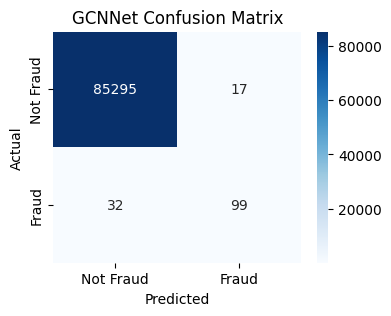

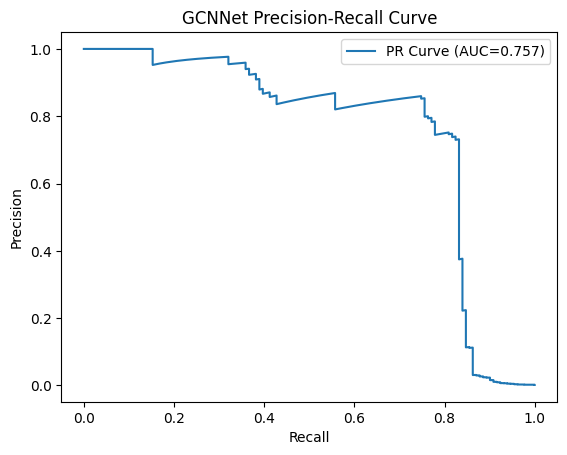

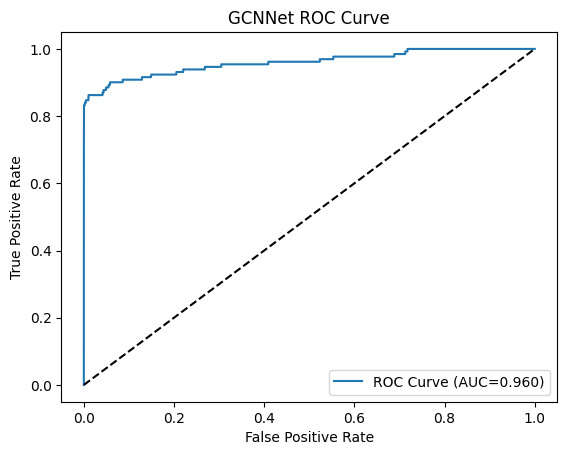

In [ ]:
results_sage = run_single_experiment(GCNNet, train_data, val_data, test_data, num_epochs=100)
#to hange GNN variant change the first 'GCNNet' to 'GATNet' or 'GraphSAGENet



In [ ]:
for model_name, res in results.items():
    print(f"{model_name} keys: {list(res.keys())}")


GraphSAGE keys: ['model', 'train_losses', 'val_losses', 'train_accs', 'val_accs', 'best_threshold', 'best_f1', 'preds', 'labels', 'probs']
GAT keys: ['model', 'train_losses', 'val_losses', 'train_accs', 'val_accs', 'best_threshold', 'best_f1', 'preds', 'labels', 'probs']
GCN keys: ['model', 'train_losses', 'val_losses', 'train_accs', 'val_accs', 'best_threshold', 'best_f1', 'preds', 'labels', 'probs']


In [ ]:
def plot_training_curves(results, metric='loss', save_path=None):
    plt.figure(figsize=(12, 8))
    for model_name, res in results.items():
        train_key = f'train_{metric}s'
        val_key = f'val_{metric}s'
        if train_key not in res or val_key not in res:
            print(f"Skipping {model_name} due to missing keys.")
            continue
        train_metric = res[train_key]
        val_metric = res[val_key]
        plt.plot(train_metric, label=f'{model_name} Train')
        plt.plot(val_metric, label=f'{model_name} Val')

    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation {metric.capitalize()} over Epochs')
    plt.legend()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()




Plot saved to training_validation_accuracy.png


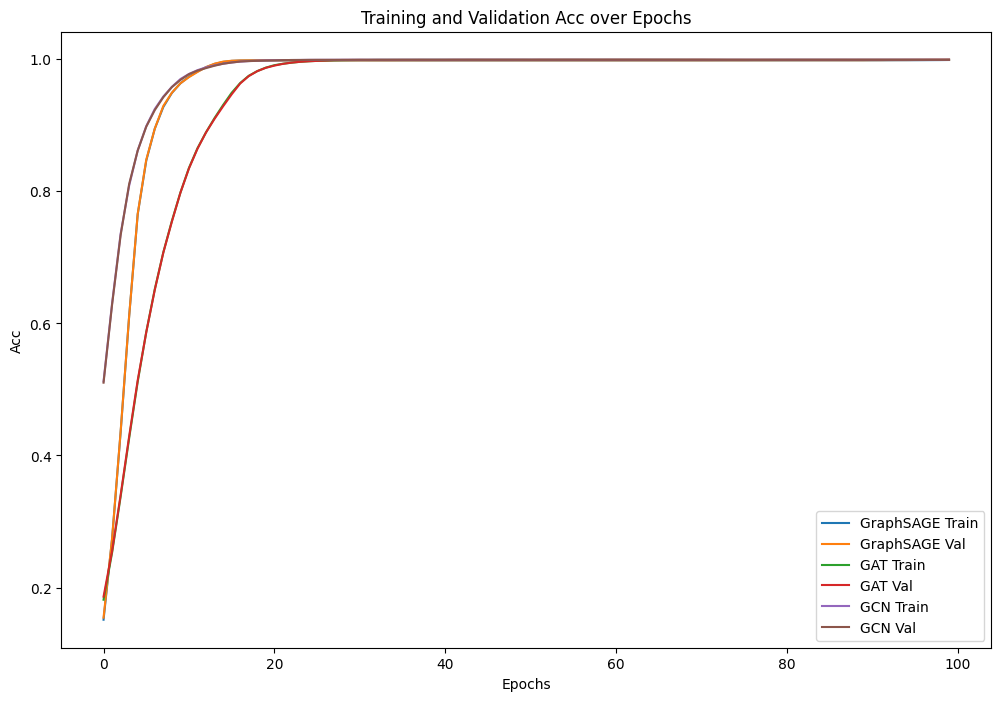

In [ ]:
plot_training_curves(results, metric='acc', save_path='training_validation_accuracy.png')
